In [78]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


In [105]:
traffic_processed = pd.read_csv("processed_traffic.csv")

traffic_processed.tail()

avgFare_backup = traffic_processed["avgFare"]

In [83]:
# Rearrange columns of pd dataframe
new_column_order = ['avgFare', 'distance', 'airline_id_hotkey', "airline_id", "avgDelay"]
traffic_processed = traffic_processed[new_column_order]

traffic_processed.head()

,avgFare,distance,airline_id_hotkey,airline_id,avgDelay
0,432.582599,1773.0,1,AA,8.25
1,432.582599,1773.0,1,AA,6.25
2,148.681660,632.0,1,AA,9.00
3,148.953222,600.0,1,AA,5.00
4,382.463768,1587.0,1,AA,38.25


          avgFare  distance  avgDelay  airline_id_hotkey
0        0.353063  0.351777  0.014625           0.000000
1        0.353063  0.351777  0.010969           0.000000
2        0.121350  0.121365  0.015996           0.000000
3        0.121572  0.114903  0.008684           0.000000
4        0.312157  0.314216  0.069470           0.000000
...           ...       ...       ...                ...
1018941  0.104568  0.104806  0.007313           0.727273
1018942  0.444370  0.455775  0.068556           0.727273
1018943  0.172777  0.177302  0.013254           0.727273
1018944  0.252342  0.240509  0.047075           0.727273
1018945  0.033705  0.032310  0.105119           0.727273

[1018946 rows x 4 columns]
         avgFare  distance  airline_id_hotkey
337377  0.212805  0.171244           0.818182
872780  0.059773  0.059774           0.818182
575174  0.330161  0.341276           0.909091
155242  0.276799  0.256260           0.818182
58406   0.152228  0.147415           0.181818
...         

c:\Users\shiva\OneDrive\Documents\GitHub\Projects\Work\Citadel-Datathon\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\shiva\AppData\Local\Temp\ipykernel_25224\2615809812.py:62: RuntimeWarning: divide by zero encountered in log
  aic = len(y_pred) * np.log(k) + 2 * len(params)


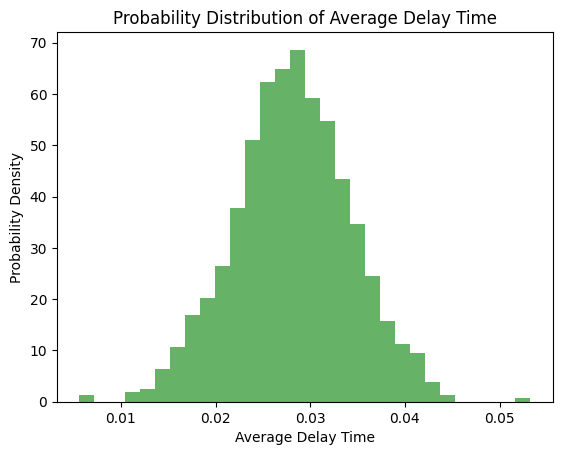

In [84]:
# Select the numeric columns that you want to normalize
numeric_columns = ['avgFare', 'distance', 'avgDelay', 'airline_id_hotkey']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

test = pd.DataFrame()

# Fit and normalize the selected numeric columns
test[numeric_columns] = scaler.fit_transform(traffic_processed[numeric_columns])

print(test)

X = test[['avgFare', 'distance', 'airline_id_hotkey']]
y = test['avgDelay']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train)
print(X_val)
print(y_train)
print(y_val)

# Train the XGBoost regression model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Calculate the root mean squared error (RMSE) as the evaluation metric
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse}")

# Check if the data is approximately normally distributed
# Using Shapiro-Wilk test (null hypothesis: data is normally distributed)
_, p_value = stats.shapiro(y_pred)
is_normal = p_value > 0.05

print(is_normal)

# If data is not normally distributed, try to find the best-fitting distribution
if not is_normal:
    # Candidate distributions to consider
    candidate_distributions = [
        stats.norm,        # Normal distribution
        stats.expon,       # Exponential distribution
        stats.gamma,       # Gamma distribution
        stats.lognorm,     # Log-normal distribution
        stats.weibull_min  # Weibull distribution (minimum)
    ]
    
    # Fit different distributions and find the best one based on minimum AIC (Akaike Information Criterion)
    best_distribution = None
    best_params = ()
    best_aic = float("inf")
    
    for distribution in candidate_distributions:
        params = distribution.fit(y_pred)
        _, k = stats.kstest(y_pred, distribution(*params).cdf)
        aic = len(y_pred) * np.log(k) + 2 * len(params)
        if aic < best_aic:
            best_distribution = distribution
            best_params = params
            best_aic = aic

    # Generate the probability distribution using the best-fitting distribution
    prob_distribution = best_distribution(*best_params).rvs(size=1000)
else:
    # If data is normally distributed, use the predicted values directly
    prob_distribution = y_pred


# Plot the probability distribution
plt.hist(prob_distribution, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Average Delay Time')
plt.ylabel('Probability Density')
plt.title('Probability Distribution of Average Delay Time')
plt.show()


In [88]:
def predict_avg_delay(avgFare, distance, airline_id):
    # Assuming 'df' is the DataFrame containing the dataset

    # Find the airline_id_hotkey for the given airline_id
    matching_rows = traffic_processed.loc[traffic_processed['airline_id'] == airline_id, 'airline_id_hotkey']
    if matching_rows.any():
        airline_id_hotkey = matching_rows.values[0]
    else:
        raise ValueError(f"No matching airline_id found for: {airline_id}")

    # Prepare the input for prediction
    input_data = pd.DataFrame({'avgFare': [avgFare], 'distance': [distance], 'airline_id_hotkey': [airline_id_hotkey]})

    # Use the trained model to predict the average delay
    predicted_delay = model.predict(input_data)[0]

    # Check if the data is approximately normally distributed
    # Using Shapiro-Wilk test (null hypothesis: data is normally distributed)
    _, p_value = stats.shapiro(y_pred)
    is_normal = p_value > 0.05

    if not is_normal:
        # If data is not normally distributed, use the best-fitting distribution for probability calculation
        probability = np.mean(prob_distribution >= predicted_delay)
    else:
        # If data is normally distributed, use None as probability (not applicable)
        probability = None

    return predicted_delay, probability

In [108]:
# this is how the model was trained
# Train the XGBoost regression model
# model = xgb.XGBRegressor()
# model.fit(X_train, y_train)

airline_id = 'AA'
distance = .5
avgFare = .8

predicted_delay, probability = predict_avg_delay(avgFare= avgFare, distance= distance, airline_id= airline_id)

print(f"Predicted Average Delay: {predicted_delay}")
if probability is not None:
    print(f"Probability of Delay >= Predicted Delay: {probability}")
else:
    print("Probability calculation is not available for normal distribution case.")


print(type(predicted_delay))


# # Assuming 'scaler' is the MinMaxScaler object used for normalization

# # Example normalized value (replace this with your actual normalized value)
# normalized_value = predicted_delay

# # Reshape the normalized value to a 2D array before using inverse_transform
# normalized_value_reshaped = np.array([[normalized_value]])

# # Use inverse_transform on the reshaped value to get the unnormalized value
# unnormalized_value = scaler.inverse_transform(normalized_value_reshaped)

# # Access the original value from the unnormalized result
# original_value = unnormalized_value[0, 0]

# print(f"Original Value: {original_value}")

Predicted Average Delay: 0.03674273192882538
Probability of Delay >= Predicted Delay: 0.084
<class 'numpy.float32'>


c:\Users\shiva\OneDrive\Documents\GitHub\Projects\Work\Citadel-Datathon\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [109]:
model.save_model("main.model")